# Building a Safe Haven

In [2]:
import numpy as np
import pandas as pd
import math

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%matplotlib inline

# Widgets
from ipywidgets import interact

# Optimization
from scipy.optimize import fsolve
from scipy.stats import gmean

# Runtime measurements
import time

# Working with dates
import datetime
from dateutil.relativedelta import relativedelta

# Financial Data
import quandl

# Auto-reload modules
%load_ext autoreload
%autoreload 2

# Setting local module path
import os
import sys
module_path = os.path.abspath(os.path.join('../modules')) 
sys.path.insert(0, module_path)

# Local module import
import petersburgmerchant
import nietzschesdemon
import kellycriterion
import bet


## Chapter Two: Nature's Admonition

### The Saint Petersburg Paradox

In [3]:
# Setting payoff in currency of choice
payoffs = bet.Bet('payoffs', [1, 2, 6, 22, 200, 1000000], [1, 1, 1, 1, 1, 1])

payoffs.outcomes

array([1.0e+00, 2.0e+00, 6.0e+00, 2.2e+01, 2.0e+02, 1.0e+06])

In [4]:
# Setting amount of wealth and size of bet in chosen currency (hey, don't use another one. This is no currency converter)
wealth_amount = 100000
bet_size = 50000

### Emolumentum Medium

Ending wealth per bet
$$ \text{Ending Wealth} = \text{Starting Wealth} - Wager + Payoff $$

For Elolumentum Medium of all bets, were $ n_{wealth} $ is the amount of bets
$$ EM =  \frac{\sum(\log(\text{Ending Wealth}_{n}))}{n_{wealth}} $$

Bernouilli's Expected Value (BEV) is calculated by the exponential function of EM
$$ BEV = e^{EM} $$

In [5]:
# Calculating wager corresponding to set bet_size
wager = petersburgmerchant.bev(payoffs.outcomes, wealth_amount, bet_size) 
print(wager)


83113.90899349027


If we do the Saint Petersburg Wager with a wealth of 100000 and a bet of 50000 under the given payoffs, we expect final wealth of 83.113, which makes it less than our original wealth. Therefore we shouldn't bet.

### Geometric Average

#### Solution 1: Iterating through possible solutions of BEV

In [6]:
def bet_size_solution1(payoffs, wealth_amount):
    """
    Calculate the optimal bet size using iteration through bev().

    Arguments:
    - payoffs: A list of payoff values
    - wealth_amount: The total wealth amount

    Returns:
    - bet_size: The optimal bet size
    - runtime: The execution time in seconds
    """
    bet_size = 0
    epsilon = 0.001  # Accuracy of the estimate
    max_iterations = wealth_amount + 1  # Maximum number of iterations

    start_time = time.time()  # Start time for runtime measurement

    for _ in range(max_iterations):
        # Calculation of BEV for the current bet
        wager = petersburgmerchant.bev(payoffs, wealth_amount, bet_size)

        # Finding the solution
        if abs(wager - wealth_amount) < epsilon:
            break

        # Update the bet size based on the difference between the wager and wealth_amount
        bet_size += wager - wealth_amount

    end_time = time.time()  # End time for runtime measurement
    runtime = end_time - start_time

    return int(bet_size), runtime

bet_size, runtime = bet_size_solution1(payoffs.outcomes, wealth_amount)
print("Optimal Bet Size:", bet_size)
print("Runtime:", runtime, "seconds")


Optimal Bet Size: 37708
Runtime: 0.00015544891357421875 seconds


This calculation is nothing else than the calculation of the geometric mean.

$$ \text{GM} = \sqrt[n]{(x_1 + k) \cdot (x_2 + k) \cdot \ldots \cdot (x_n + k)} = \left( (x_1 + k)\cdot (x_2 + k)\cdot \ldots \cdot (x_n + k)\right)^{\frac{1}{n}} $$

#### Solution 2: Finding the correct formula with 'fsolve' for given list

In [7]:
def bet_size_solution2(wealth_amount, payoffs):
    """
    Calculate the optimal bet size using the geometric mean method.
    
    Arguments:
    - wealth_amount: Total wealth amount
    - payoffs: List of payoffs for each possible outcome of the bet
    
    Returns:
    - bet_size: Optimal bet size
    - runtime: Runtime in seconds
    """
    n = len(payoffs)
    
    # Function for calculating the geometric mean
    def geom_mean(bet_size):
        product = 1
        for value in payoffs:
            product *= value + bet_size
        return math.pow(product, 1/n) - wealth_amount
    
    # Using 'fsolve' from SciPy to calculate bet_size
    initial_guess = 0  # Starting value for bet_size
    
    start_time = time.time()  # Starting time for runtime measurement
    bet_size = wealth_amount - fsolve(geom_mean, initial_guess)
    end_time = time.time()  # End time for runtime measurement
    runtime = end_time - start_time
    
    return int(bet_size[0]), runtime

bet_size, runtime = bet_size_solution2(wealth_amount, payoffs.outcomes)
print("Optimal Bet Size:", bet_size)
print("Runtime:", runtime, "seconds")

Optimal Bet Size: 37708
Runtime: 0.0011942386627197266 seconds


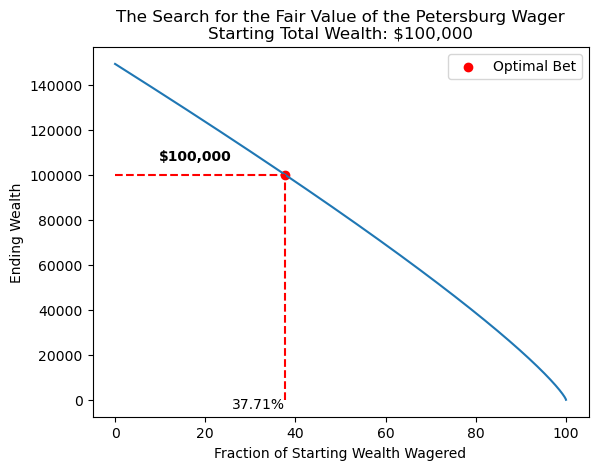

In [8]:
petersburgmerchant.plot_betting(payoffs.outcomes, wealth_amount, bet_size)

### The other Saint Petersburg Paradox

In [9]:
interact(petersburgmerchant.investment_recovery_plot, loss_value=(-95, -5), step=1)

interactive(children=(IntSlider(value=-50, description='loss_value', max=-5, min=-95), Output()), _dom_classes…

<function petersburgmerchant.investment_recovery_plot(loss_value)>

## Chapter Three: The Eternal Return

### Dice with Schrödinger's Demon (N = 1)

In [10]:
# Setting dice rules
dice = bet.Bet('dice roll', [0.5, 1.05, 1.5], [1, 4, 1])

dice.outcomes

array([0.5 , 1.05, 1.05, 1.05, 1.05, 1.5 ])

In [11]:
# Monte Carlo Simulation settings
num_rolls = 300
num_walks = 10000

In [12]:
# Calculating the average of a weighted dice roll in percent, cutting off at two decimal places
schroedingers_dice = (np.average(dice.results, weights=dice.weights) - 1 ) * 100
schroedingers_dice = round(schroedingers_dice, 2)
print("Dice with Schrödinger's Demon (N = 1):", schroedingers_dice, "%")

Dice with Schrödinger's Demon (N = 1): 3.33 %


### Dice with Nietzsche's Demon (N = ∞)

In [13]:
# Calculating the geometric mean of a weighted dice roll in percent, cutting off at two decimal places
nietzsches_dice = (gmean(dice.results, weights=dice.weights) - 1 ) * 100
nietzsches_dice = round(nietzsches_dice, 2)
print("Dice with Nietzsche's Demon (N = ∞):", nietzsches_dice, "%")

Dice with Nietzsche's Demon (N = ∞): -1.53 %


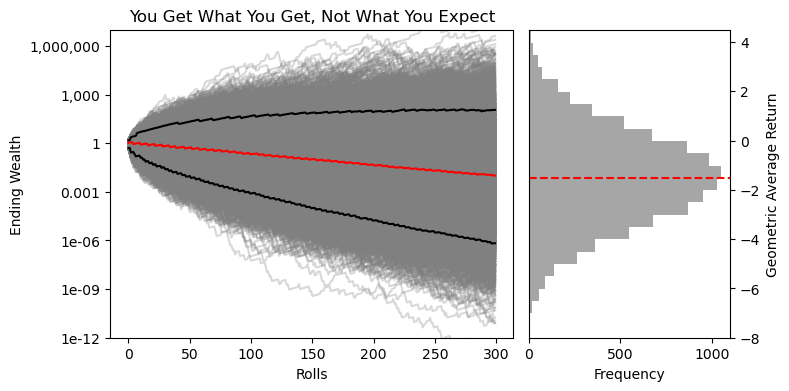

In [14]:
# Plotting frequency distribution of given number of random walks and rolls
nietzschesdemon.plot_random_walk_frequency_distribution(num_walks, num_rolls, dice.outcomes, 'You Get What You Get, Not What You Expect')

### The Hustle of Non-Ergodicity

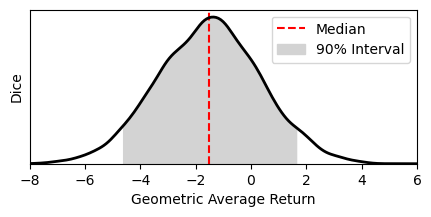

In [15]:
# The median ending wealth, the expected log of ending wealth, and the median
# and expected growth rate all correspond to the same thing.
nietzschesdemon.plot_random_walk_geom_average(num_walks, num_rolls, dice, "Dice")

### Magic or Math Trick

In [16]:
# Outcome of cash (no win/no loss)
cash = bet.Bet('cash', [1, 1, 1], [1, 4, 1])
cash.outcomes

array([1., 1., 1., 1., 1., 1.])

In [17]:
# Setting ratio for dice to cash
ratio = np.array([0.4, 0.6])

In [18]:
dice_to_cash = bet.BetComparison(dice, cash, ratio)
dice_to_cash.__dict__

{'bet1_name': 'dice roll',
 'bet2_name': 'cash',
 'dice roll': <bet.Bet at 0x7ff655403810>,
 'cash': <bet.Bet at 0x7ff6553be710>,
 'ratio': array([0.4, 0.6]),
 'arith_mean_combined': 1.333333333333342,
 'geom_mean_combined': 0.6418597249604252,
 'cost': -2.0000000000000018,
 'net': 2.1720550138149552,
 'outcomes': array([0.8 , 1.02, 1.02, 1.02, 1.02, 1.2 ])}

In [19]:
# Showing arithmetic mean of a combined wager of dice and cash
print("Arithmetic mean of the dice:", dice.arith_mean.round(2), "%")
print("Arithmetic mean of the cash:", cash.arith_mean.round(2), "%")
print("Arithmetic mean of the combined wager:", dice_to_cash.arith_mean_combined.round(2), "%")
print("Cost:", dice_to_cash.cost.round(2), "%")

Arithmetic mean of the dice: 3.33 %
Arithmetic mean of the cash: 0.0 %
Arithmetic mean of the combined wager: 1.33 %
Cost: -2.0 %


In [20]:
# Showing geometric mean of a combined wager of dice and cash
print("Geometric mean of the dice:", dice.geom_mean.round(2), "%")
print("Geometric mean of the cash:", cash.geom_mean.round(2), "%")
print("Geometric mean of the combined wager:", dice_to_cash.geom_mean_combined.round(2), "%")
print("Net:", dice_to_cash.net.round(2), "%")

Geometric mean of the dice: -1.53 %
Geometric mean of the cash: 0.0 %
Geometric mean of the combined wager: 0.64 %
Net: 2.17 %


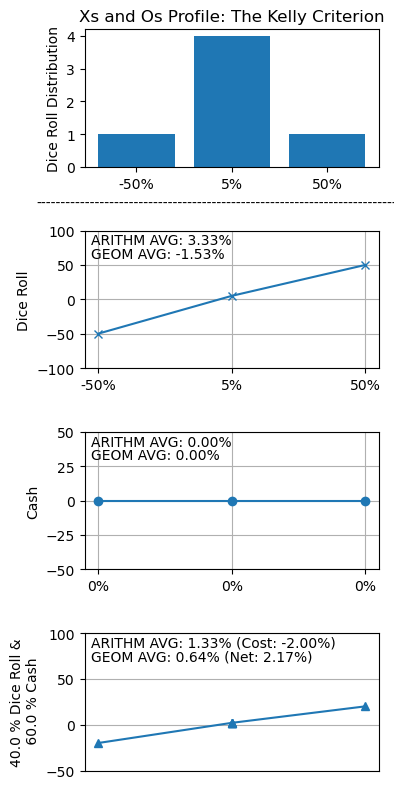

In [21]:
kellycriterion.plot_xo_profile(dice, cash, dice_to_cash, "The Kelly Criterion")

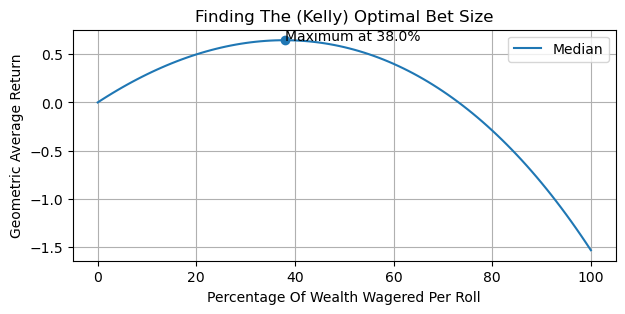

In [22]:
kellycriterion.plot_kelly_optimal(dice.outcomes, cash.outcomes)

In [23]:
optimal_outcomes = kellycriterion.combined_outcomes(dice.outcomes, cash.outcomes, np.array([0.38, 0.62]))
optimal_outcomes

array([0.81 , 1.019, 1.019, 1.019, 1.019, 1.19 ])

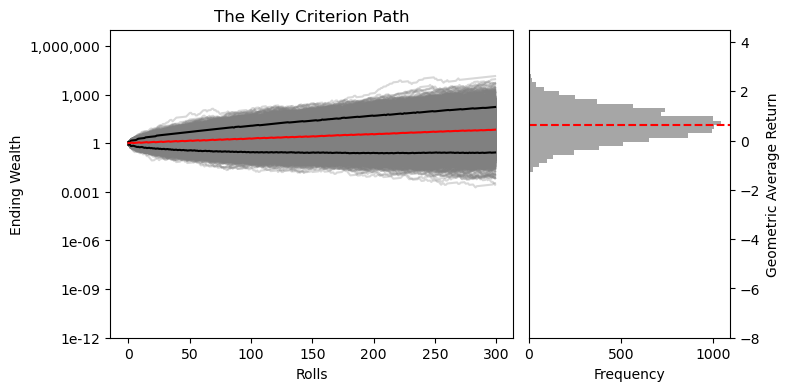

In [24]:
nietzschesdemon.plot_random_walk_frequency_distribution(num_walks, num_rolls, optimal_outcomes, 'The Kelly Criterion Path')

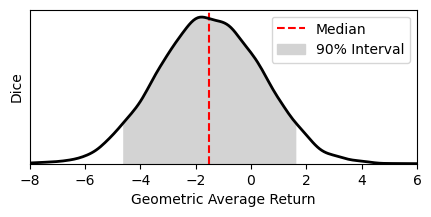

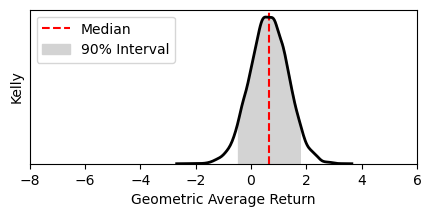

In [25]:
# Arithmetic Cost vs. Net Portfolio Effect: The All-In Bets vs. The Kelly-sized Bets
nietzschesdemon.plot_random_walk_geom_average(num_walks, num_rolls, dice, "Dice")
nietzschesdemon.plot_random_walk_geom_average(num_walks, num_rolls, dice_to_cash, "Kelly")

### Side Bets

In [26]:
# Insurance bet: 500% plus means a 6
insurance = bet.Bet('insurance', [6, 0, 0], [1, 4, 1])
insurance.outcomes

array([6., 0., 0., 0., 0., 0.])

In [33]:
# Setting ratio for dice to insurance
dice_to_insurance_ratio = np.array([0.91, 0.09])

In [34]:
# Creating new BetComparison object for dice to insurance
dice_to_insurance = bet.BetComparison(dice, insurance, dice_to_insurance_ratio)
dice_to_insurance.__dict__

{'bet1_name': 'dice roll',
 'bet2_name': 'insurance',
 'dice roll': <bet.Bet at 0x7ff655403810>,
 'insurance': <bet.Bet at 0x7ff6519c9190>,
 'ratio': array([0.91, 0.09]),
 'arith_mean_combined': 3.0333333333333545,
 'geom_mean_combined': 2.0891880210412994,
 'cost': -0.29999999999998916,
 'net': 3.6193833098958295,
 'outcomes': array([0.995 , 0.9555, 0.9555, 0.9555, 0.9555, 1.365 ])}

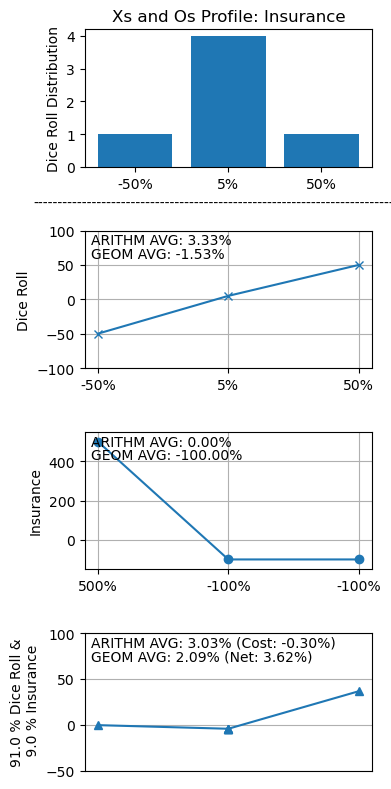

In [35]:
# Plotting XO profile for dice to insurance
kellycriterion.plot_xo_profile(dice, insurance, dice_to_insurance, "Insurance")

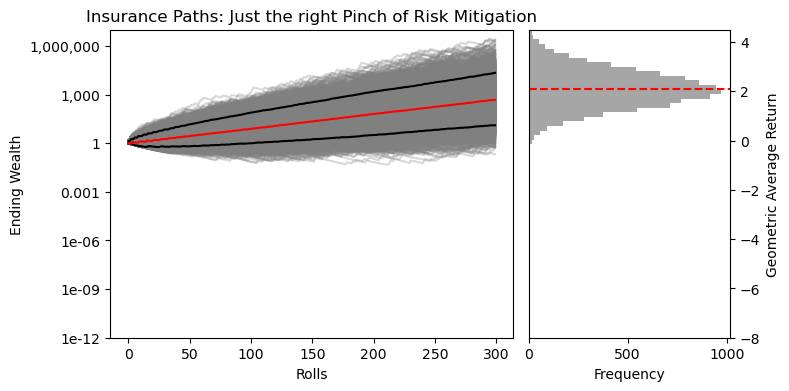

In [36]:
# Plotting insurance paths
nietzschesdemon.plot_random_walk_frequency_distribution(num_walks, num_rolls, dice_to_insurance.outcomes, 'Insurance Paths: Just the right Pinch of Risk Mitigation')

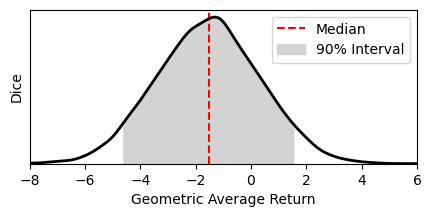

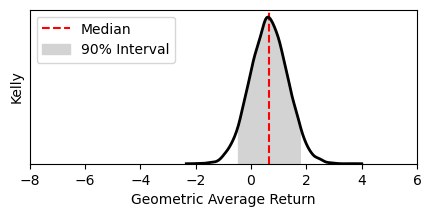

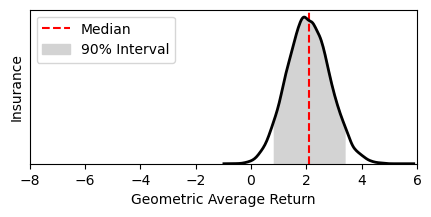

In [37]:
# The All‐In Bets vs. The Kelly‐sized Bets vs. the Insured Bets
nietzschesdemon.plot_random_walk_geom_average(num_walks, num_rolls, dice, "Dice")
nietzschesdemon.plot_random_walk_geom_average(num_walks, num_rolls, dice_to_cash, "Kelly")
nietzschesdemon.plot_random_walk_geom_average(num_walks, num_rolls, dice_to_insurance, "Insurance")

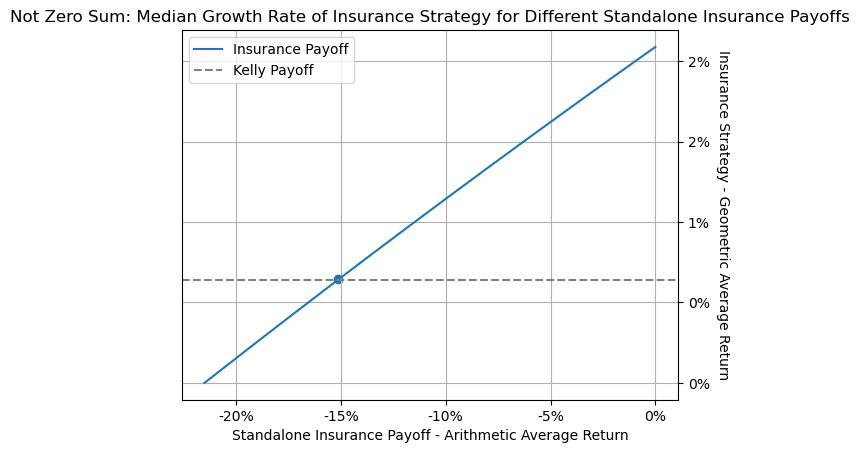

In [39]:
# Dropping payoff calculation and plotting: What happens if the insurance payoffs gets lower? Insurance is most certainly not a zero‐sum game.
nietzschesdemon.plot_median_growth(dice_to_insurance_ratio, dice.outcomes, insurance.outcomes, dice_to_cash.geom_mean_combined)

## Chapter Four: A Taxonomy

### Inductive Dice

In [ ]:
# Loading the API key from a credentials.txt file in `notebooks` directory
with open('credentials.txt', 'r') as f:
    api_key = f.read().strip()

quandl.ApiConfig.api_key = api_key

In [ ]:
# Setting date range
end_date = datetime.date.today().replace(month=1, day=1)
start_date = end_date - relativedelta(years=120)

In [ ]:
# Loading S&P 500 yearly data from date range
sp500 = quandl.get("MULTPL/SP500_REAL_PRICE_YEAR", start_date=start_date, end_date=end_date)
sp500

,Value
Date,
1903-01-01,8.46
1904-01-01,6.68
1905-01-01,8.43
1906-01-01,9.87
1907-01-01,9.56
...,...
2022-10-31,3871.98
2022-11-01,3856.10
2022-11-30,4080.11


In [ ]:
# Filtering of data that do not correspond to January 1.
sp500 = sp500[sp500.index.month == 1]
sp500 = sp500[sp500.index.day == 1]
sp500.shape

(121, 1)

In [ ]:
# Adding the percentage change from the previous year as a new column
sp500['Return'] = sp500['Value'].pct_change()
sp500

,Value,Return
Date,,
1903-01-01,8.46,NaN
1904-01-01,6.68,-0.210402
1905-01-01,8.43,0.261976
1906-01-01,9.87,0.170819
1907-01-01,9.56,-0.031408
...,...,...
2019-01-01,2607.39,-0.065385
2020-01-01,3278.20,0.257273
2021-01-01,3793.75,0.157266


In [ ]:
# Defining bin boundaries and labels
bin_edges = [-float('inf'),-0.15,0,0.15,0.3,float('inf')]
bin_labels = ['< -15%', '-15% to 0%', '0% to 15%', '15% to 30%', '> 30%']

In [ ]:
sp500['ReturnRange'] = pd.cut(sp500['Return'], bin_edges, labels=bin_labels)
sp500.head()

,Value,Return,ReturnRange
Date,,,
1903-01-01,8.46,NaN,NaN
1904-01-01,6.68,-0.210402,< -15%
1905-01-01,8.43,0.261976,15% to 30%
1906-01-01,9.87,0.170819,15% to 30%
1907-01-01,9.56,-0.031408,-15% to 0%


In [ ]:
# Safe data to CSV
sp500.to_csv("../output/sp500.csv", sep=";")

In [ ]:
# Count return range values
sp500["ReturnRange"].value_counts()

0% to 15%     39
15% to 30%    30
-15% to 0%    28
< -15%        13
> 30%         10
Name: ReturnRange, dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of SPX Annual Returns, 1903-2023')

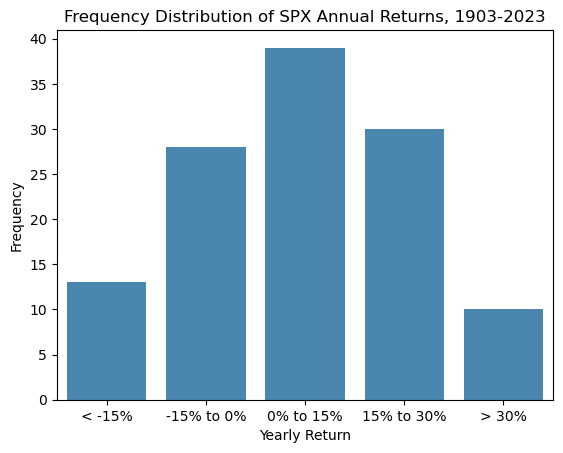

In [ ]:
# Create yearly returns of S&P 500 plot
sns.countplot(x='ReturnRange', data=sp500, color='#3a89bf')

# Set axis labels and titles
plt.xlabel('Yearly Return')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of SPX Annual Returns, ' + start_date.strftime('%Y') + '-' + end_date.strftime('%Y'))